In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyroomacoustics as pra

In [2]:
corpus = pra.datasets.CMUArcticCorpus(download=True, speaker=['bdl'])
sample = corpus.samples[0]

clean = sample.data
fs = sample.fs

In [3]:
corners = np.array([[0, 0], [0, 3], [5, 3], [5, 1], [3, 1], [3, 0]]).T  # [x,y] in metres
room = pra.Room.from_corners(corners, fs=sample.fs, ray_tracing=True,
                             air_absorption=True, materials=pra.Material(0.2, 0.15))

In [4]:
room.add_source([1.5, 1.5], signal=sample.data)

In [5]:
R = np.array([[1, 2, 1.5], [1, 1., 2]])  # [[x], [y], [z]]
print(R)

M1 = R[:,0]
M2 = R[:,1]
M3 = R[:,2]
print(M3)

[[1.  2.  1.5]
 [1.  1.  2. ]]
[1.5 2. ]


In [6]:
room.add_microphone(R)

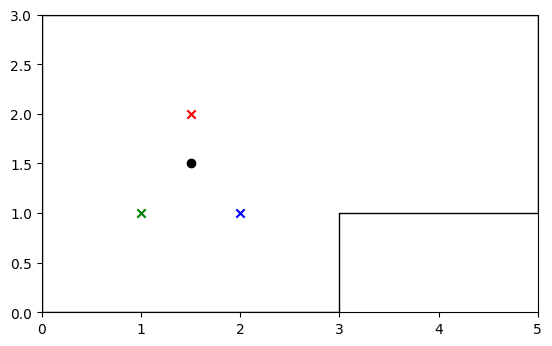

In [7]:
fig, ax = room.plot()
ax.set_xlim([0, 5])
ax.set_ylim([0, 3])
plt.scatter(M1[0], M1[1], c="g", marker="x")
plt.scatter(M2[0], M2[1], c="b", marker="x")
plt.scatter(M3[0], M3[1], c="r", marker="x")
plt.scatter(1.5, 1.5, marker="o", c="k")

plt.savefig("room.png", dpi=400,bbox_inches='tight')

(<Figure size 640x480 with 3 Axes>,
 array([[<Axes: title={'center': 'Source 0'}>],
        [<Axes: >],
        [<Axes: xlabel='Time (ms)'>]], dtype=object))

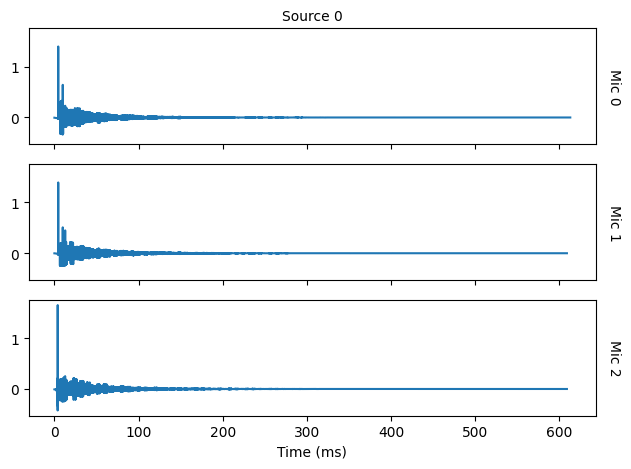

In [8]:
room.compute_rir()

room.plot_rir()

In [9]:
room.simulate()
print(room.mic_array.signals.shape)

(3, 61570)


In [10]:
x1 = room.mic_array.signals[0, :]
x2 = room.mic_array.signals[1, :]
x3 = room.mic_array.signals[2, :]

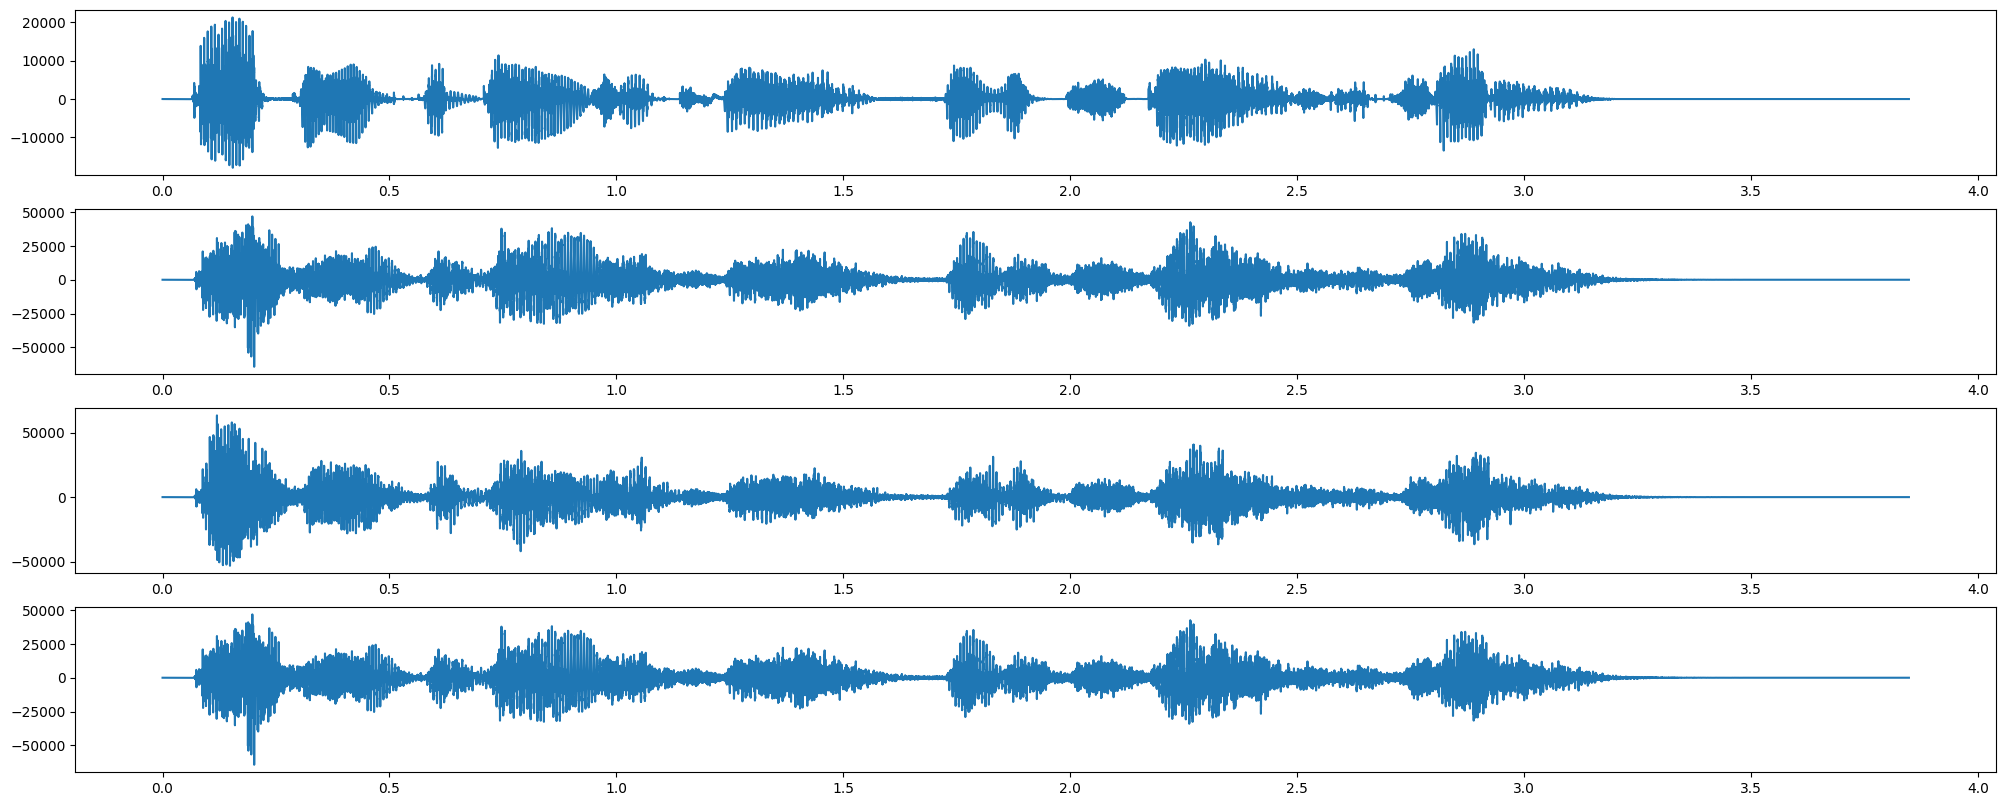

In [11]:
N = max(len(sample.data), len(x1))
t = np.arange(N) / sample.fs

if len(x1) < N:
    x1 = np.concatenate((x1, np.zeros(N - len(x1))))
if len(sample.data) < N:
    signal = np.concatenate((sample.data, np.zeros(N - len(sample.data))))
else:
    signal = sample.data

fig = plt.figure()
fig.set_size_inches(20, 8)
plt.subplot(4, 1, 1)
plt.plot(t, signal)
plt.subplot(4, 1, 2)
plt.plot(t, x1)
plt.subplot(4, 1, 3)
plt.plot(t, x2)
plt.subplot(4, 1, 4)
plt.plot(t, x1)
plt.tight_layout(pad=0.5)

In [12]:

# get energy
T = int(fs * 0.02)   # 200 ms
T = len(x1)
y1 = np.zeros(len(x1)//T)
y2 = np.zeros(len(x2)//T)
y3 = np.zeros(len(x3)//T)

for l in range(0, len(y1)):
    y1[l] = np.mean(x1[l * T: (l + 1) * T] ** 2)
    y2[l] = np.mean(x2[l * T: (l + 1) * T] ** 2)
    y3[l] = np.mean(x3[l * T: (l + 1) * T] ** 2)

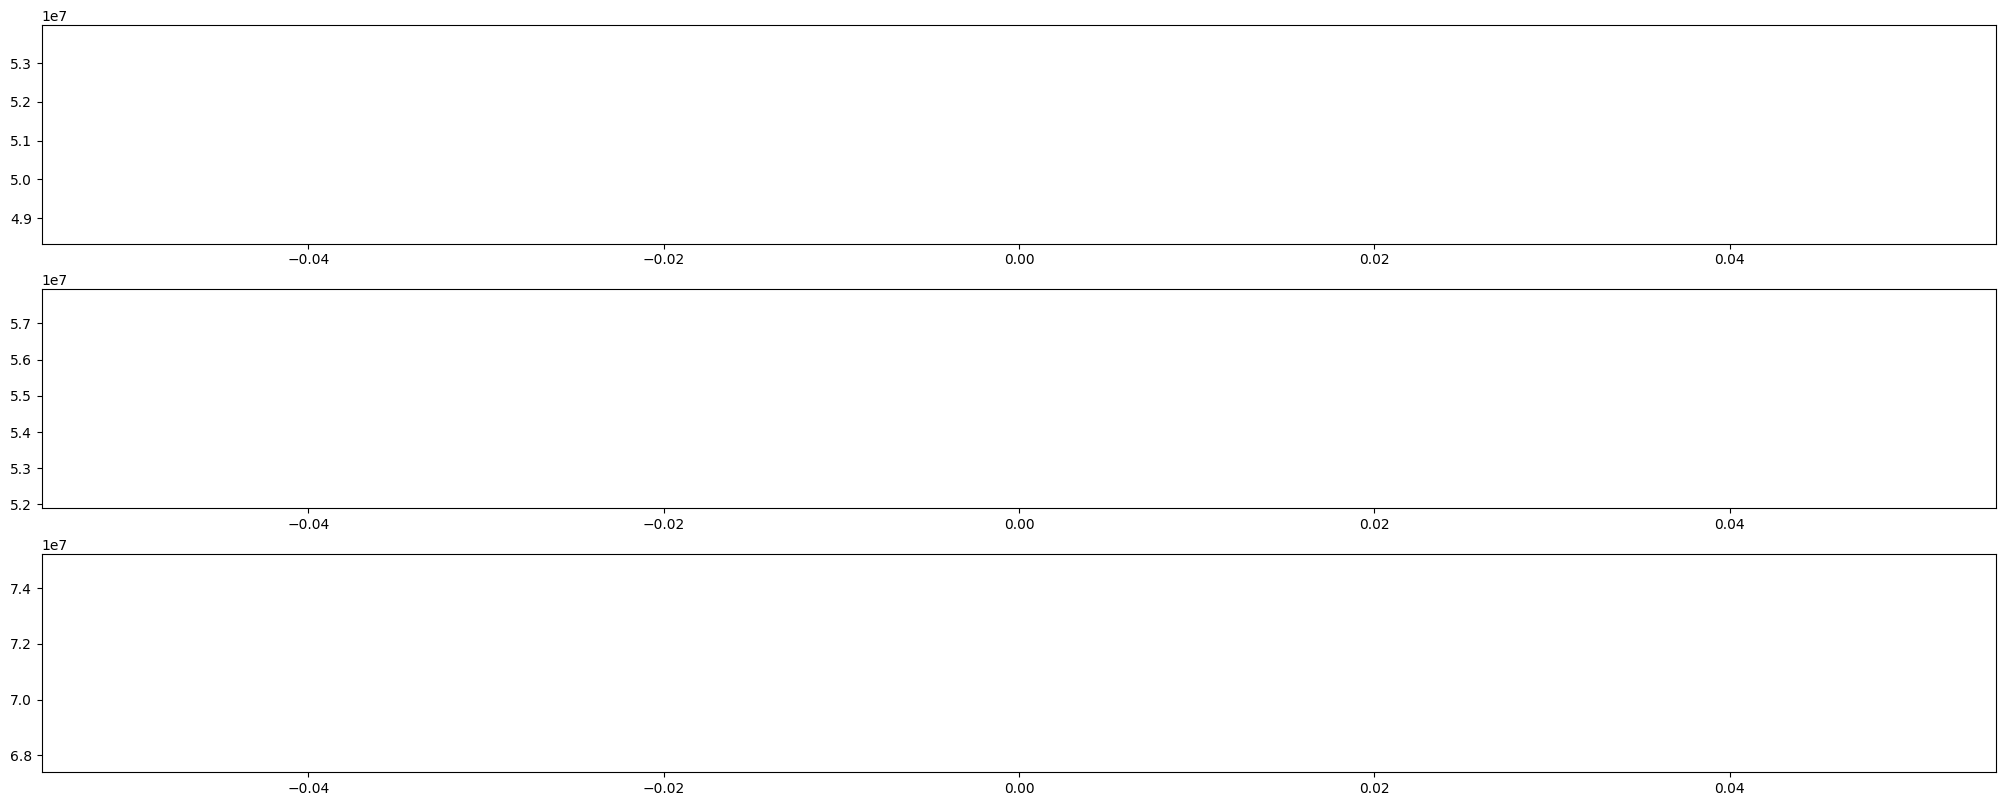

In [13]:
t_energy = np.arange(len(y1)) / fs

fig = plt.figure()
fig.set_size_inches(20, 8)
plt.subplot(3, 1, 1)
plt.plot(t_energy, y1)
plt.subplot(3, 1, 2)
plt.plot(t_energy, y2)
plt.subplot(3, 1, 3)
plt.plot(t_energy, y3)
plt.tight_layout(pad=0.5)

In [14]:
kappa_12 = ((y1/y2) / (1) ) ** (-1/2)
kappa_13 = ((y1/y3) / (1) ) ** (-1/2)
kappa_23 = ((y2/y3) / (1) ) ** (-1/2)
kappa_21 = 1/kappa_12
kappa_31 = 1/kappa_13
kappa_32 = 1/kappa_23

print(kappa_12)
print(kappa_13)
print(kappa_23)

[1.03607117]
[1.18059916]
[1.13949621]


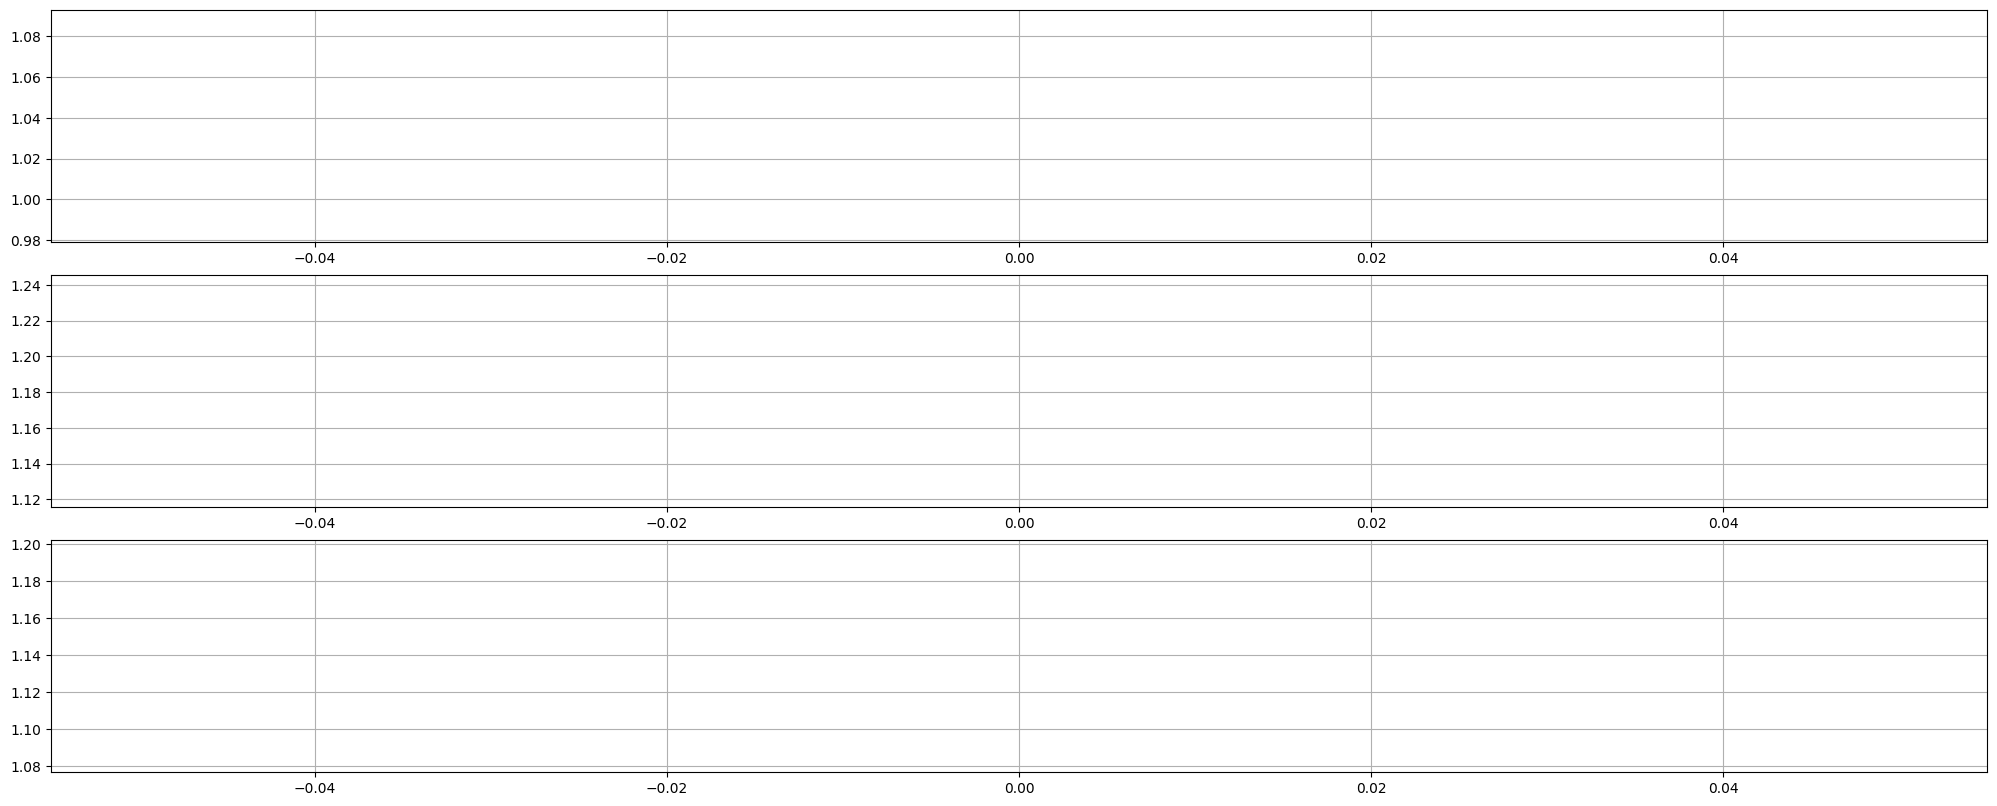

In [15]:
t_energy = np.arange(len(y1)) / fs

fig = plt.figure()
fig.set_size_inches(20, 8)
plt.subplot(3, 1, 1)
plt.plot(t_energy, kappa_12)
plt.grid()
plt.subplot(3, 1, 2)
plt.plot(t_energy, kappa_13)
plt.grid()
plt.subplot(3, 1, 3)
plt.plot(t_energy, kappa_23)
plt.grid()
plt.tight_layout(pad=0.5)

In [16]:
def norm(x: np.ndarray):
    return np.sqrt(x[0]**2 + x[1]**2)

In [18]:
# Hyperspheres

c12 = (M1 - kappa_12**2 * M2) / (1-kappa_12**2)
c13 = (M1 - kappa_13**2 * M3) / (1-kappa_13**2)
c23 = (M3 - kappa_32**2 * M2) / (1-kappa_32**2)

rho_12 = np.abs(kappa_12 * norm(M1 - M2) / (1-kappa_12**2))
rho_13 = np.abs(kappa_13 * norm(M2 - M3) / (1-kappa_13**2))
rho_23 = np.abs(kappa_23 * norm(M2 - M3) / (1-kappa_23**2))

print(c12)
print(c13)
print(c23)

print(rho_12)
print(rho_13)
print(rho_23)

[15.6159159  1.       ]
[2.76963367 4.53926734]
[-0.17531351  5.35062701]
[14.10705787]
[3.3517059]
[4.26868369]


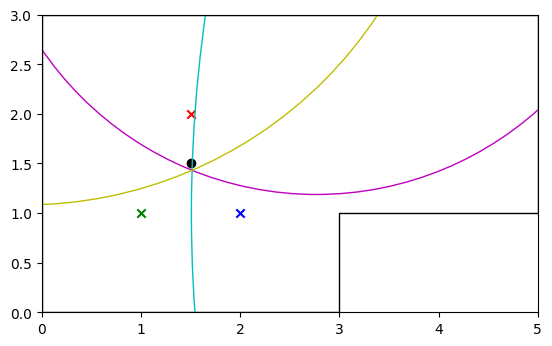

In [21]:
# fig, ax = plt.subplots(1,1)
# ax.set_xlim([0, 5])
# ax.set_ylim([0, 3])
fig, ax = room.plot()
ax.set_xlim([0, 5])
ax.set_ylim([0, 3])

plt.scatter(M1[0], M1[1], c="g", marker="x")
plt.scatter(M2[0], M2[1], c="b", marker="x")
plt.scatter(M3[0], M3[1], c="r", marker="x")
plt.scatter(1.5, 1.5, marker="o", c="k")
circle1 = plt.Circle(c12, rho_12, fill=False, color="c")
circle2 = plt.Circle(c13, rho_13, fill=False, color="m")
circle3 = plt.Circle(c23, np.abs(rho_23), fill=False, color="y")

ax.add_patch(circle1)
ax.add_patch(circle2)
ax.add_patch(circle3)

plt.savefig("hyperplanes.png", dpi=400, bbox_inches='tight')

0.0
0.0


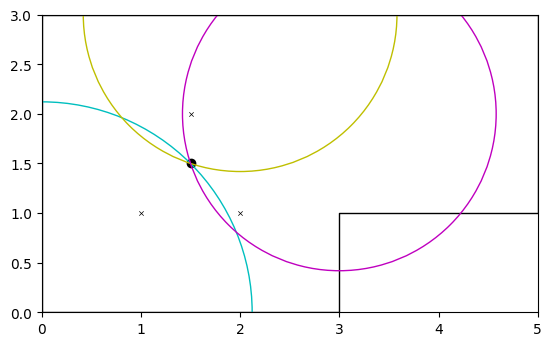

In [22]:
def cost(r, c, rho):
    ret = 0
    # if r == np.array([1.5,1.5]):
    #     print("h")
    ret = 0
    P = len(rho)
    for p in range(P):
        centre = c[p]
        rad = rho[p]
        ret += (norm(r - c[p]) - rho[p])**2
    # for c_p, rho_p in zip(c, rho):
    #     ret += (norm(r - c_p) - rho_p) **2

    return ret

P = 3*(3-1)//2
x_tmp = np.array([1.5, 1.5])
c_tmp = np.array([[0,0], [2,3], [3,2]])
r_tmp = np.array([np.sqrt((x_tmp[0]-i[0])**2 + (x_tmp[1] - i[1])**2) for i in c_tmp])


fig, ax = room.plot()
ax.set_xlim([0, 5])
ax.set_ylim([0, 3])

plt.scatter(1.5, 1.5, marker="o", c="k")
circle1 = plt.Circle(c_tmp[0], r_tmp[0], fill=False, color="c")
circle2 = plt.Circle(c_tmp[1], r_tmp[1], fill=False, color="y")
circle3 = plt.Circle(c_tmp[2], r_tmp[2], fill=False, color="m")

ax.add_patch(circle1)
ax.add_patch(circle2)
ax.add_patch(circle3)

ret = 0
for p in range(P):
    ret += (norm(x_tmp - c_tmp[p]) - r_tmp[p])**2

print(ret)
ret = cost(x_tmp, c_tmp, r_tmp)
print(ret)

In [42]:

delta = 0.05
x = np.arange(0,3, delta)
y = np.arange(0,3, delta)
X, Y = np.meshgrid(x, y)

J = np.zeros_like(X)

centres = np.array([c12, c13, c23])
radia = np.array([rho_12, rho_13, rho_23]).flatten()

j = cost(np.array([1.5,1.5]), centres, radia)

for i in range(X.shape[0]):
    for j in range(Y.shape[1]):
        r = np.array([X[i, j], Y[i, j]])
        J[i, j] = cost(r, centres, radia)
print(J)

idx = np.unravel_index(J.argmin(),J.shape)
print(idx)
X_opt = X[idx]
Y_opt = Y[idx]
print(X_opt, Y_opt)

[[7.41537368 7.16711403 6.92752705 ... 6.63417491 6.862845   7.10019423]
 [7.13411579 6.88739506 6.64930628 ... 6.36639392 6.59389758 6.83003659]
 [6.86248566 6.61730541 6.38071588 ... 6.10727275 6.33356899 6.56845591]
 ...
 [5.73404448 5.57275172 5.41650724 ... 4.33422565 4.42079014 4.51026692]
 [5.93781165 5.77761035 5.62233714 ... 4.50784837 4.59033199 4.67546293]
 [6.14825987 5.98909312 5.83472868 ... 4.68778974 4.76612364 4.84682317]]
(29, 30)
1.5 1.4500000000000002


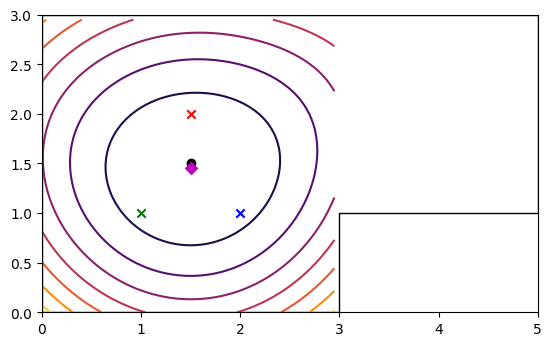

In [50]:
fig, ax = room.plot()
ax.set_xlim([0, 5])
ax.set_ylim([0, 3])

plt.scatter(M1[0], M1[1], c="g", marker="x")
plt.scatter(M2[0], M2[1], c="b", marker="x")
plt.scatter(M3[0], M3[1], c="r", marker="x")
plt.scatter(1.5, 1.5, marker="o", c="k")
plt.scatter(X_opt, Y_opt, marker="D", c="m")
# circle1 = plt.Circle(c12, rho_12, fill=False, color="c")
# circle2 = plt.Circle(c13, rho_13, fill=False, color="m")
# circle3 = plt.Circle(c23, rho_23, fill=False, color="y")

# ax.add_patch(circle1)
# ax.add_patch(circle2)
# ax.add_patch(circle3)

CS = ax.contour(X, Y, J, cmap="inferno")

plt.savefig("optimization.png", dpi=400, bbox_inches='tight')

In [ ]:
## find location: gradient descent with cost function defined in paper

## or.. use eq (11)


## see Weighted Least-Squares Solutions for Energy-Based Collaborative Source Localization Using Acoustic Array
# for description on how to get the least squares solution